this script plot the funding pattern of global science

In [2]:
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch

In [3]:
pubs_path="../../data/nf_folder/Data/DerivedData/CleanedRawData/pub.pkl"

global_funding_path='/u/miaoli/ember_home/dropbox/NationalFunding/Figs/Figs/global_funding.pdf'

In [5]:
pubs_df = pd.read_pickle(pubs_path)
pubs_df.head()

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol,cofund,intfund
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[United States, Canada]",[United States],1,1,0,0
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0,0,0
2,55323671,2015,89,1,"[France, Chile]","[Chile, Chile, Chile, Chile, Chile]","[Chile, France]",[Chile],1,1,0,0
3,57633115,2016,31,1,"[Switzerland, United States]",[Switzerland],"[Switzerland, United States]",[Switzerland],1,1,0,0
4,64831413,2018,99,1,[China],"[China, China, China, China, China, China]",[China],[China],1,0,0,0


## calculate the funding ratio over year

In [7]:
#assign funding types to publications
def ftype(funded,cofund):
    label="null"
    if funded==0:
        label='Not-Funded'
    elif funded==1 and cofund==0:
        label='single'
    elif funded==1 and cofund==1:
        label='Cofund'
    return label
pubs_df['ftype']=pubs_df[['funded','cofund']].apply(lambda x:ftype(x.funded,x.cofund),axis=1)

In [8]:
pubs_df.head()

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol,cofund,intfund,ftype
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[United States, Canada]",[United States],1,1,0,0,single
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0,0,0,Not-Funded
2,55323671,2015,89,1,"[France, Chile]","[Chile, Chile, Chile, Chile, Chile]","[Chile, France]",[Chile],1,1,0,0,single
3,57633115,2016,31,1,"[Switzerland, United States]",[Switzerland],"[Switzerland, United States]",[Switzerland],1,1,0,0,single
4,64831413,2018,99,1,[China],"[China, China, China, China, China, China]",[China],[China],1,0,0,0,single


In [9]:
def cal_fundtype(df):
    fdtype=df.groupby(['year','ftype']).size().reset_index(name='count')
    fdtype = fdtype.pivot(index='year',columns='ftype',values='count')
    fdtype = fdtype.div(fdtype.sum(axis=1), axis=0)
    fdtype = fdtype.reset_index().melt(id_vars='year',var_name='type', value_name='value')
    funded=fdtype[fdtype.type=='Not-Funded']
    funded['value']=1-funded['value']
    funded['type']='Funded'
    fdtype = pd.concat([fdtype,funded])
    return fdtype

In [10]:
fdtype=cal_fundtype(pubs_df)

<ipython-input-9-7100e7dd7ba7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funded['value']=1-funded['value']
<ipython-input-9-7100e7dd7ba7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funded['type']='Funded'


In [11]:
fdtype.head(5)

,year,type,value
0,2009,Cofund,0.077263
1,2010,Cofund,0.099982
2,2011,Cofund,0.110767
3,2012,Cofund,0.111941
4,2013,Cofund,0.111349


In [12]:
df=pubs_df[pubs_df.IntCol==1]
colltype=cal_fundtype(df)

<ipython-input-9-7100e7dd7ba7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funded['value']=1-funded['value']
<ipython-input-9-7100e7dd7ba7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funded['type']='Funded'


In [13]:
colltype.head(5)

,year,type,value
0,2009,Cofund,0.233071
1,2010,Cofund,0.290632
2,2011,Cofund,0.314999
3,2012,Cofund,0.313685
4,2013,Cofund,0.306588


In [14]:
df=pubs_df[pubs_df.IntCol==0]
dometype=cal_fundtype(df)

<ipython-input-9-7100e7dd7ba7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funded['value']=1-funded['value']
<ipython-input-9-7100e7dd7ba7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funded['type']='Funded'


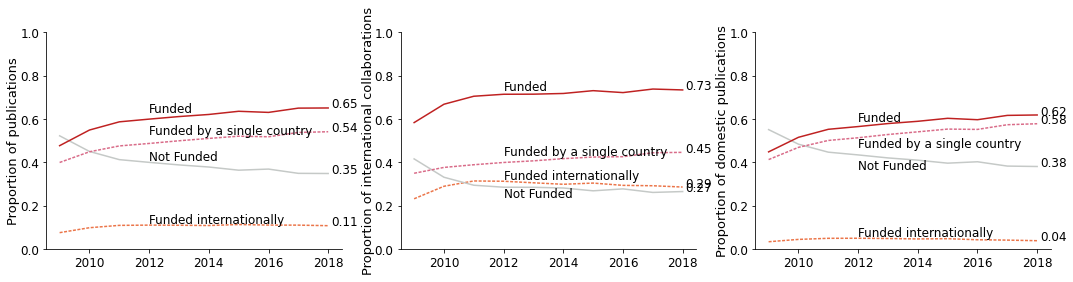

In [20]:
def plot_type(df,ax,ylabel,text,texty,values):
    sns.lineplot(x='year',y='value',hue='type',
             palette={'Cofund':'#EB7549','single':'#D96C89','Not-Funded':'#C5C9C7','Funded':'#BF2121'},
             data=df,legend=False,style='type',dashes={'Cofund':(2,1),'single':(2,1),'Not-Funded':'','Funded':''},
             ax=ax)
    ax.set_xticks(np.arange(2010,2019,2))
    ax.set_xlabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(ylabel,fontsize=13,labelpad=0)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_ylim(0,1)
    
    for t, ty in zip(text,texty):
        ax.text(2012,ty,s=t,fontsize=12)
    for v in values:
        ax.text(2018.1,v,s=str(np.around(v,decimals=2)),fontsize=12)
    return ax

fig, ax=plt.subplots(nrows=1,ncols=3,figsize=(18,4))
ax0=ax[0]
ax1=ax[1]
ax2=ax[2]

text=["Funded by a single country","Not Funded","Funded internationally","Funded"]
texty=[0.53,0.41,0.12,0.63]
ylabel='Proportion of publications'
values=fdtype[fdtype.year==2018].value.tolist()
ax0=plot_type(fdtype,ax0,ylabel,text,texty,values)

ylabel='Proportion of international collaborations'
texty=[0.43,0.24,0.32,0.73]
values=colltype[colltype.year==2018].value.tolist()
ax1=plot_type(colltype,ax1,ylabel,text,texty,values)

ylabel='Proportion of domestic publications'
texty=[0.47,0.37,0.06,0.59]
values=dometype[dometype.year==2018].value.tolist()
ax2=plot_type(dometype,ax2,ylabel,text,texty,values)
plt.savefig(global_funding_path,bbox_inches='tight')